In [1]:
import argparse
import traceback
import shutil
import logging
import yaml
import sys
import os
import torch
import numpy as np
from torch.utils.data import Subset, Dataset
import torchvision.transforms as transforms
import math
import torch.nn as nn
import torch.utils.data as data
import random
import requests
import tqdm
import torchvision.utils as tvu
import torchvision
import cv2
from PIL import Image
import torch.utils
import torch.utils.data
import matplotlib.pyplot as plt

## Setup

In [2]:
# Hyperparameters
model_image_size = 256
beta_start = 0.0001
beta_end = 0.02
num_diffusion_timesteps = 1000

model_out_ch = 3
model_ch = 128
model_ch_mult = [1, 1, 2, 2, 4, 4]
model_num_res_blocks = 2
model_attn_resolutions = [16, ]
model_dropout = 0.0
model_in_channels = 3
model_resamp_with_conv = True

sampling_batch_size = 1

data_num_workers = 32
data_channels = 3

time_travel_T_sampling = 100
time_travel_travel_length = 1
time_travel_travel_repeat = 1

In [3]:
project_path = "ECE285-Final-Project/"

gt_path = "gt_test"
mask_path = "mask_test"

gt_vis_path = "gt_vis"
mask_vis_path = "mask_vis"

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device: {}".format(device))

Using device: cuda


In [5]:
# set random seed
torch.manual_seed(1234)
np.random.seed(1234)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1234)

torch.backends.cudnn.benchmark = True

## Complete Test Data

In [6]:
class ImageMaskDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    self.mask_paths = [os.path.join(mask_dir, os.path.basename(f).split('.')[0] + '.png') for f in self.image_paths]  # mask filenames match image filenames (except for extension)

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    mask_path = self.mask_paths[idx]

    # print(image_path)
    # print(mask_path)

    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')

    if self.transform:
      image = self.transform(image)
      mask = self.transform(mask)

    return image, mask, os.path.basename(image_path).split('.')[0]

image_dir = os.path.join(project_path, gt_path)
mask_dir = os.path.join(project_path, mask_path)

transform = transforms.Compose([transforms.Resize([model_image_size, model_image_size]),
                                        transforms.ToTensor()])

image_mask_dataset = ImageMaskDataset(image_dir, mask_dir, transform)
print(len(image_mask_dataset))
print(image_mask_dataset[0])

710
(tensor([[[0.3922, 0.4510, 0.4941,  ..., 0.6196, 0.6078, 0.5059],
         [0.4588, 0.4510, 0.4118,  ..., 0.5647, 0.6196, 0.6000],
         [0.4902, 0.4588, 0.3961,  ..., 0.5569, 0.6000, 0.6275],
         ...,
         [0.7843, 0.7686, 0.3451,  ..., 0.3216, 0.3176, 0.3176],
         [0.7098, 0.6706, 0.3451,  ..., 0.3176, 0.3176, 0.3137],
         [0.7255, 0.7373, 0.7098,  ..., 0.3176, 0.3176, 0.3137]],

        [[0.3882, 0.4471, 0.4902,  ..., 0.6118, 0.6000, 0.4980],
         [0.4549, 0.4471, 0.4078,  ..., 0.5569, 0.6118, 0.5922],
         [0.4863, 0.4549, 0.3922,  ..., 0.5490, 0.5922, 0.6196],
         ...,
         [0.7765, 0.7608, 0.3373,  ..., 0.2157, 0.2118, 0.2118],
         [0.7020, 0.6627, 0.3373,  ..., 0.2118, 0.2118, 0.2078],
         [0.7176, 0.7294, 0.7020,  ..., 0.2118, 0.2118, 0.2078]],

        [[0.3804, 0.4392, 0.4824,  ..., 0.6157, 0.6039, 0.5020],
         [0.4471, 0.4392, 0.4000,  ..., 0.5608, 0.6157, 0.5961],
         [0.4784, 0.4471, 0.3843,  ..., 0.5529, 0.596

## Util

In [7]:
#utility functions

def data_transform(X):
    X = 2 * X - 1.0
    return X


def inverse_data_transform(X):

    X = (X + 1.0) / 2.0

    return torch.clamp(X, 0.0, 1.0)

def get_beta_schedule(beta_start, beta_end, num_diffusion_timesteps):

    betas = np.linspace(
        beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
    )

    assert betas.shape == (num_diffusion_timesteps,)
    return betas

def get_schedule_jump(T_sampling, travel_length, travel_repeat):
    jumps = {}
    for j in range(0, T_sampling - travel_length, travel_length):
        jumps[j] = travel_repeat - 1

    t = T_sampling
    ts = []

    while t >= 1:
        t = t-1
        ts.append(t)

        if jumps.get(t, 0) > 0:
            jumps[t] = jumps[t] - 1
            for _ in range(travel_length):
                t = t + 1
                ts.append(t)

    ts.append(-1)

    _check_times(ts, -1, T_sampling)
    return ts

def _check_times(times, t_0, T_sampling):
    assert times[0] > times[1], (times[0], times[1])

    assert times[-1] == -1, times[-1]

    for t_last, t_cur in zip(times[:-1], times[1:]):
        assert abs(t_last - t_cur) == 1, (t_last, t_cur)

    for t in times:
        assert t >= t_0, (t, t_0)
        assert t <= T_sampling, (t, T_sampling)

def compute_alpha(beta, t):
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
    return a

def get_timestep_embedding(timesteps, embedding_dim):
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb


def nonlinearity(x):
    return x*torch.sigmoid(x) # swish

def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)

def ssim(img1, img2):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())
    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1 ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2 ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

## Model

In [8]:
# Model definition and forward pass for diffusion model based on SDEdit paper implementation

class Upsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        x = torch.nn.functional.interpolate(
            x, scale_factor=2.0, mode="nearest")
        if self.with_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=2,
                                        padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0, 1, 0, 1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0)
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x
    
class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, conv_shortcut=False,
                 dropout, temb_channels=512):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 = Normalize(in_channels)
        self.conv1 = torch.nn.Conv2d(in_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        self.temb_proj = torch.nn.Linear(temb_channels,
                                         out_channels)
        self.norm2 = Normalize(out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(in_channels,
                                                     out_channels,
                                                     kernel_size=3,
                                                     stride=1,
                                                     padding=1)
            else:
                self.nin_shortcut = torch.nn.Conv2d(in_channels,
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0)

    def forward(self, x, temb):
        h = x
        h = self.norm1(h)
        h = nonlinearity(h)
        h = self.conv1(h)

        h = h + self.temb_proj(nonlinearity(temb))[:, :, None, None]

        h = self.norm2(h)
        h = nonlinearity(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x+h
    
class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)
        
    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b, c, h, w = q.shape
        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)   
        k = k.reshape(b, c, h*w)  
        w_ = torch.bmm(q, k)  
        w_ = w_ * (int(c)**(-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b, c, h*w)
        w_ = w_.permute(0, 2, 1)
        h_ = torch.bmm(v, w_)
        h_ = h_.reshape(b, c, h, w)

        h_ = self.proj_out(h_)

        return x+h_
    
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        ch, out_ch, ch_mult = model_ch, model_out_ch, tuple(model_ch_mult)
        num_res_blocks = model_num_res_blocks
        attn_resolutions = model_attn_resolutions
        dropout = model_dropout
        in_channels = model_in_channels
        resolution = model_image_size
        resamp_with_conv = model_resamp_with_conv
        

        self.ch = ch
        self.temb_ch = self.ch*4
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # timestep embedding
        self.temb = nn.Module()
        self.temb.dense = nn.ModuleList([
            torch.nn.Linear(self.ch,
                            self.temb_ch),
            torch.nn.Linear(self.temb_ch,
                            self.temb_ch),
        ])

        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+ch_mult
        self.down = nn.ModuleList()
        block_in = None
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = AttnBlock(block_in)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            skip_in = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                if i_block == self.num_res_blocks:
                    skip_in = ch*in_ch_mult[i_level]
                block.append(ResnetBlock(in_channels=block_in+skip_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up) 

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        out_ch,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x, t):
        assert x.shape[2] == x.shape[3] == self.resolution

        # timestep embedding
        temb = get_timestep_embedding(t, self.ch)
        temb = self.temb.dense[0](temb)
        temb = nonlinearity(temb)
        temb = self.temb.dense[1](temb)

        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb)
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](
                    torch.cat([h, hs.pop()], dim=1), temb)
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h

In [9]:
model = Model().to(device)
print(model)

Model(
  (temb): Module(
    (dense): ModuleList(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0-1): 2 x Module(
      (block): ModuleList(
        (0-1): 2 x ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (temb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (attn): ModuleList()
      (downsample): Downsample(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
      )
    )
    (2): Module(
      (block): ModuleList(
 

## DDNM

In [10]:
# Diffusion class for running DDIM with or without DDNM+ based on DDNM paper implementation
class Diffusion(object):
    def __init__(self, dataset, model_path, output_folder, device=None):
        self.dataset = dataset
        self.model_path = model_path
        self.output_folder = output_folder
        self.device = device

        betas = get_beta_schedule(
            beta_start=beta_start,
            beta_end=beta_end,
            num_diffusion_timesteps=num_diffusion_timesteps,
        )
        betas = self.betas = torch.from_numpy(betas).float().to(self.device)
        self.num_timesteps = betas.shape[0]

        alphas = 1.0 - betas
        alphas_cumprod = alphas.cumprod(dim=0)
        alphas_cumprod_prev = torch.cat(
            [torch.ones(1).to(device), alphas_cumprod[:-1]], dim=0
        )
        self.alphas_cumprod_prev = alphas_cumprod_prev
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.logvar = posterior_variance.clamp(min=1e-20).log()

    def sample(self, run_with_ddnm = True):
        model = Model()

        model.load_state_dict(torch.load(os.path.join(project_path, self.model_path), map_location=self.device))
        model.to(self.device)
        model = torch.nn.DataParallel(model)

        if run_with_ddnm:
            print("Running DDNM+...")
        else:
            print("Running DDIM without DDNM+...")
        
        self.ddnm_plus(model, run_with_ddnm)
        

    def ddnm_plus(self, model, run_with_ddnm=True):

        test_dataset = self.dataset
        subset_start = 0

        def seed_worker(worker_id):
            worker_seed = 1234 % 2 ** 32
            np.random.seed(worker_seed)
            random.seed(worker_seed)

        val_loader = data.DataLoader(
            test_dataset,
            batch_size=sampling_batch_size,
            shuffle=False,
            num_workers=data_num_workers,
            worker_init_fn=seed_worker,
            generator=torch.Generator().manual_seed(1234),
        )

        sigma_y = 0 #0.2? #Hyperparameter

        print(f'Start from {subset_start}')
        idx_init = subset_start
        curr_idx = subset_start
        avg_psnr = 0.0

        ssim_results = []
        os.makedirs(os.path.join(self.output_folder, "Apy"), exist_ok=True)
        os.makedirs(os.path.join(self.output_folder, "Gen"), exist_ok=True)

        for x_orig, mask, image_name in val_loader:
            x_orig = x_orig.to(self.device)
            x_orig = data_transform(x_orig)

            mask = mask.to(self.device)

            # DDNM core logic
            A = lambda z: z*mask
            Ap = A

            y = A(x_orig)
            Apy = Ap(y)

            # store masked image
            for i in range(len(Apy)):
                tvu.save_image(
                    inverse_data_transform(Apy[i]),
                    os.path.join(self.output_folder, f"Apy/{image_name[0]}.png")
                )

            # init x_T
            x = torch.randn(
                y.shape[0],
                data_channels,
                model_image_size,
                model_image_size,
                device=self.device,
            )

            with torch.no_grad():
                skip = num_diffusion_timesteps//time_travel_T_sampling
                n = x.size(0)
                x0_preds = []
                xs = [x]

                times = get_schedule_jump(time_travel_T_sampling,
                                               time_travel_travel_length,
                                               time_travel_travel_repeat,
                                              )
                time_pairs = list(zip(times[:-1], times[1:]))


                # reverse diffusion sampling
                for i, j in time_pairs:
                    i, j = i*skip, j*skip
                    if j<0: j=-1

                    if j < i: 
                        # normal sampling
                        t = (torch.ones(n) * i).to(x.device)
                        next_t = (torch.ones(n) * j).to(x.device)
                        at = compute_alpha(self.betas, t.long())
                        at_next = compute_alpha(self.betas, next_t.long())
                        sigma_t = (1 - at_next**2).sqrt()
                        xt = xs[-1].to('cuda')

                        et = model(xt, t)

                        if et.size(1) == 6:
                            et = et[:, :3]

                        # Eq. 12
                        x0_t = (xt - et * (1 - at).sqrt()) / at.sqrt()

                        # Eq. 19
                        if sigma_t >= at_next*sigma_y:
                            lambda_t = 1.
                            gamma_t = (sigma_t**2 - (at_next*sigma_y)**2).sqrt()
                        else:
                            lambda_t = (sigma_t)/(at_next*sigma_y)
                            gamma_t = 0.

                        # Eq. 17 for noisy images
                        x0_t_hat = x0_t - lambda_t*Ap(A(x0_t) - y)

                        eta = 0.85 #hyperparameter

                        c1 = (1 - at_next).sqrt() * eta
                        c2 = (1 - at_next).sqrt() * ((1 - eta ** 2) ** 0.5)

                        xt_next = at_next.sqrt() * x0_t_hat + gamma_t * (c1 * torch.randn_like(x0_t) + c2 * et)

                        x0_preds.append(x0_t.to('cpu'))
                        xs.append(xt_next.to('cpu'))
                    else: 
                        # time-travel sampling
                        next_t = (torch.ones(n) * j).to(x.device)
                        at_next = compute_alpha(self.betas, next_t.long())
                        x0_t = x0_preds[-1].to('cuda')

                        xt_next = at_next.sqrt() * x0_t + torch.randn_like(x0_t) * (1 - at_next).sqrt()

                        xs.append(xt_next.to('cpu'))

                x = xs[-1]

            x = [inverse_data_transform(xi) for xi in x]

            # store generated image
            tvu.save_image(
                x[0], os.path.join(self.output_folder, f"Gen/{image_name[0]}.png")
            )

            # calculate PSNR
            orig = inverse_data_transform(x_orig[0])
            mse = torch.mean((x[0].to(self.device) - orig) ** 2)
            psnr = 10 * torch.log10(1 / mse)
            avg_psnr += psnr

            curr_idx += y.shape[0]

            print("curr_idx: %d PSNR: %.2f" % (curr_idx, avg_psnr / (curr_idx - idx_init)))

            # calculate SSIM
            img1 = x[0].cpu().detach().numpy()
            img2 = orig.cpu().detach().numpy()

            if not img1.shape == img2.shape:
                raise ValueError('Input images must have the same dimensions.')
            if img1.ndim == 2:
                ssim_out = ssim(img1, img2)
            elif img1.ndim == 3:
                if img1.shape[0] == 3:
                    ssims = []
                    for i in range(3):
                        ssims.append(ssim(img1[i], img2[i]))
                    ssim_out = np.array(ssims).mean()
                elif img1.shape[0] == 1:
                    ssim_out = ssim(np.squeeze(img1), np.squeeze(img2))
            else:
                raise ValueError('Wrong input image dimensions.')

            ssim_results.append(ssim_out)

            print("curr_idx: %d SSIM: %.2f" % (curr_idx, ssim_out))


        avg_psnr = avg_psnr / (curr_idx - idx_init)

        ssim_results = np.array(ssim_results)
        ssim_mean = np.mean(ssim_results)
        ssim_std = np.std(ssim_results)

        print("Total Average PSNR: %.2f" % avg_psnr)
        print("Total SSIM mean: %.2f and std dev: %.2f" % (ssim_mean, ssim_std))
        print("Number of samples: %d" % (curr_idx - idx_init))

## Visualization

In [11]:
# Sampled images from the dataset for visualization
image_vis_dir = os.path.join(project_path, gt_vis_path)
mask_vis_dir = os.path.join(project_path, mask_vis_path)

vis_transform = transforms.Compose([transforms.Resize([model_image_size, model_image_size]),
                                        transforms.ToTensor()])

vis_dataset = ImageMaskDataset(image_vis_dir, mask_vis_dir, vis_transform)
print(len(vis_dataset))

10


### Celeba pretrained model w/ DDNM+

In [18]:
model_path = "models/celeba_hq.ckpt"
output = "gen_output_celeba_hq/"
run_with_ddnm = True

#create output folder if it doesn't exist
output_folder_celaba_1 = os.path.join(project_path, output)
if not os.path.exists(output_folder_celaba_1):
    os.makedirs(output_folder_celaba_1, exist_ok=True)


sampler = Diffusion(vis_dataset, model_path, output_folder_celaba_1, device=device)
sampler.sample(run_with_ddnm)

Running DDNM+...
Start from 0
curr_idx: 1 PSNR: 23.90
curr_idx: 1 SSIM: 0.96
curr_idx: 2 PSNR: 25.14
curr_idx: 2 SSIM: 0.96
curr_idx: 3 PSNR: 26.58
curr_idx: 3 SSIM: 0.96
curr_idx: 4 PSNR: 27.26
curr_idx: 4 SSIM: 0.97
curr_idx: 5 PSNR: 28.06
curr_idx: 5 SSIM: 0.98
curr_idx: 6 PSNR: 29.48
curr_idx: 6 SSIM: 0.99
curr_idx: 7 PSNR: 28.59
curr_idx: 7 SSIM: 0.94
curr_idx: 8 PSNR: 29.21
curr_idx: 8 SSIM: 0.98
curr_idx: 9 PSNR: 28.31
curr_idx: 9 SSIM: 0.93
curr_idx: 10 PSNR: 28.53
curr_idx: 10 SSIM: 0.96
Total Average PSNR: 28.53
Total SSIM mean: 0.96 and std dev: 0.02
Number of samples: 10


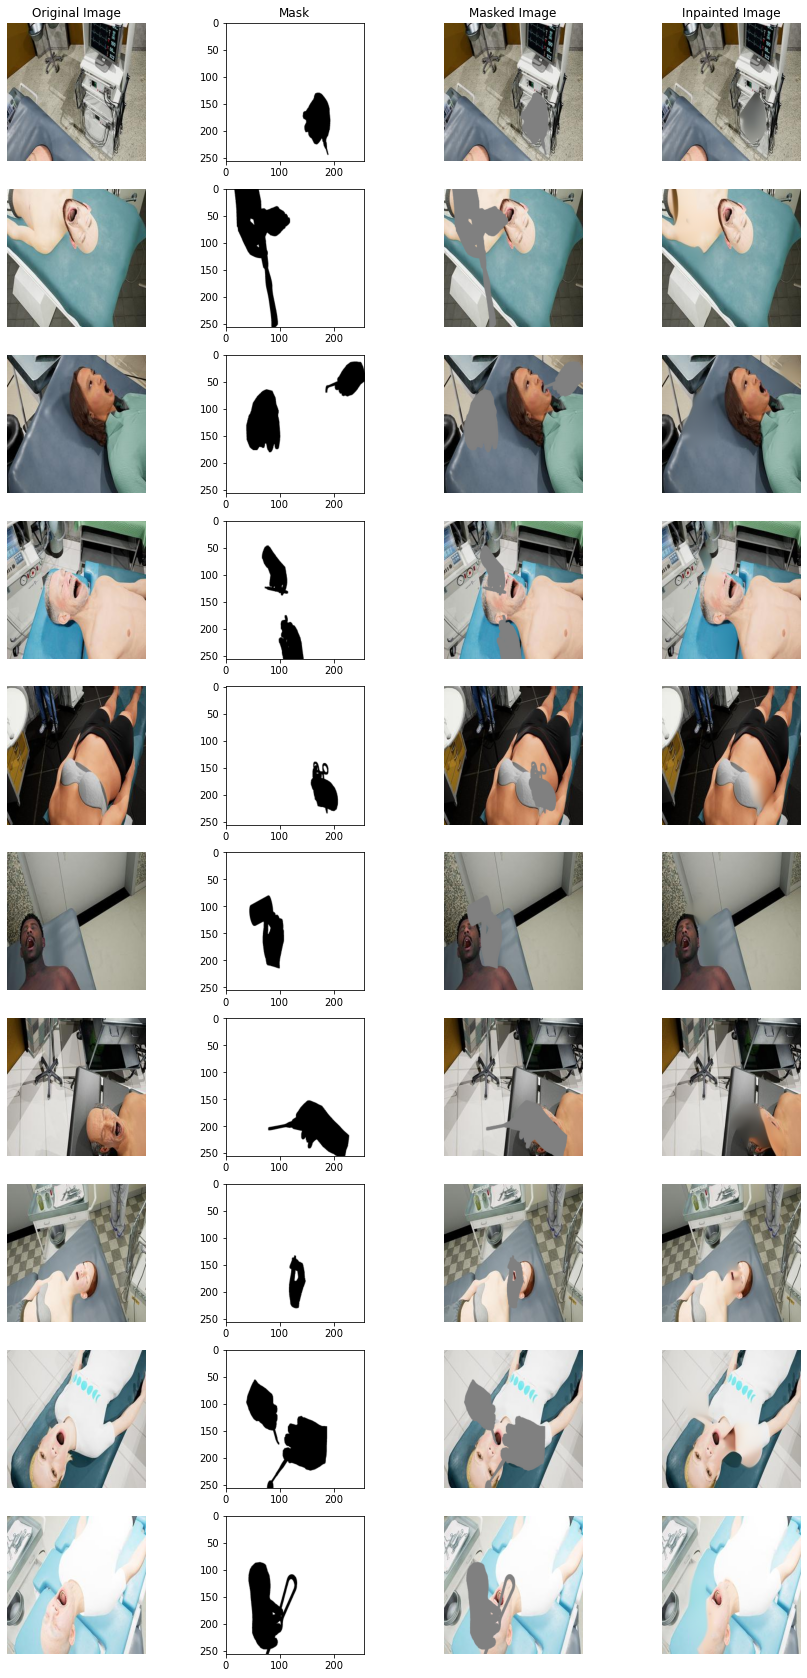

In [19]:
fig, ax = plt.subplots(len(vis_dataset), 4, figsize=(15, 30))

# print the img, mask, corresponding Apy and Gen images
for i, (img, mask, imgname) in enumerate(vis_dataset):
    # Access the image and mask data
    img = img.permute(1, 2, 0)
    mask = mask.permute(1, 2, 0)

    ax[i, 0].imshow(img)
    if i==0: ax[i, 0].set_title("Original Image")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(mask, cmap="gray")
    if i==0:  ax[i, 1].set_title("Mask")

    Apy = Image.open(os.path.join(output_folder_celaba_1, f"Apy/{imgname}.png"))
    if i==0:  ax[i, 2].set_title("Masked Image")
    ax[i, 2].imshow(Apy)
    ax[i, 2].axis("off")

    Gen = Image.open(os.path.join(output_folder_celaba_1, f"Gen/{imgname}.png"))
    if i==0:  ax[i, 3].set_title("Inpainted Image")
    ax[i, 3].imshow(Gen)
    ax[i, 3].axis("off")

plt.show()

### My Trained Model [4 epochs] w/ DDNM+

In [21]:
model_path = "models/trained_model_256r_4.pth"
output = "gen_output_256r_4/"
run_with_ddnm = True

#create output folder if it doesn't exist
output_folder_256r_4 = os.path.join(project_path, output)
if not os.path.exists(output_folder_256r_4):
    os.makedirs(output_folder_256r_4, exist_ok=True)

try:
    runner = Diffusion(vis_dataset, model_path, output_folder_256r_4, device=device)
    runner.sample(run_with_ddnm)
except Exception:
    logging.error(traceback.format_exc())

Running DDNM+...
Start from 0
curr_idx: 1 PSNR: 28.70
curr_idx: 1 SSIM: 0.96
curr_idx: 2 PSNR: 29.01
curr_idx: 2 SSIM: 0.97
curr_idx: 3 PSNR: 28.14
curr_idx: 3 SSIM: 0.95
curr_idx: 4 PSNR: 28.26
curr_idx: 4 SSIM: 0.97
curr_idx: 5 PSNR: 28.48
curr_idx: 5 SSIM: 0.98
curr_idx: 6 PSNR: 29.36
curr_idx: 6 SSIM: 0.98
curr_idx: 7 PSNR: 28.79
curr_idx: 7 SSIM: 0.94
curr_idx: 8 PSNR: 29.27
curr_idx: 8 SSIM: 0.98
curr_idx: 9 PSNR: 28.59
curr_idx: 9 SSIM: 0.94
curr_idx: 10 PSNR: 28.64
curr_idx: 10 SSIM: 0.95
Total Average PSNR: 28.64
Total SSIM mean: 0.96 and std dev: 0.01
Number of samples: 10


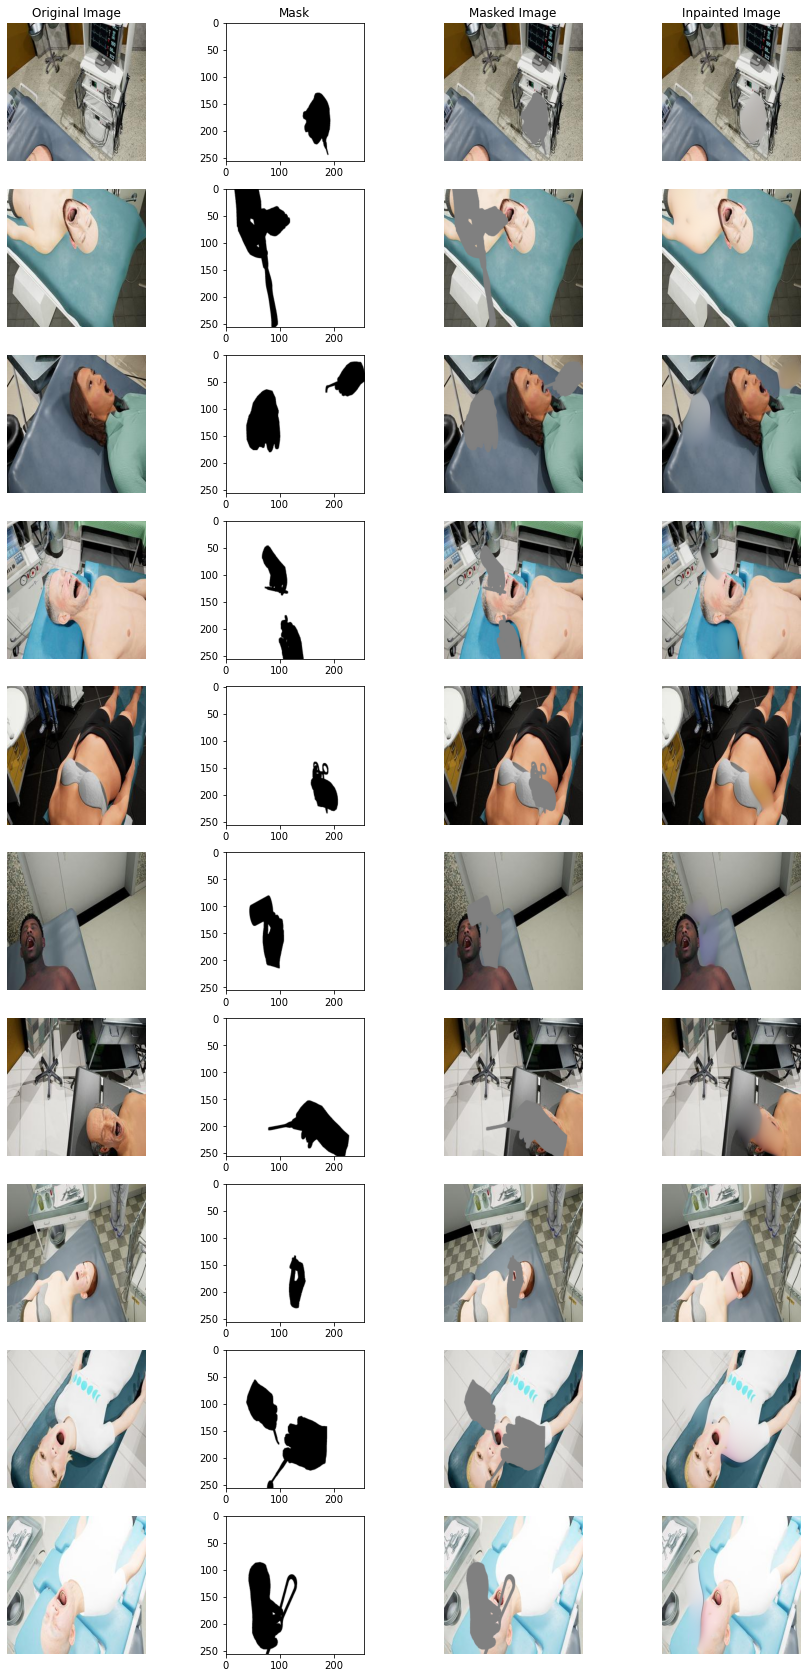

In [22]:
fig, ax = plt.subplots(len(vis_dataset), 4, figsize=(15, 30))

# print the img, mask, corresponding Apy and Gen images
for i, (img, mask, imgname) in enumerate(vis_dataset):
    # Access the image and mask data
    img = img.permute(1, 2, 0)
    mask = mask.permute(1, 2, 0)

    ax[i, 0].imshow(img)
    if i==0: ax[i, 0].set_title("Original Image")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(mask, cmap="gray")
    if i==0:  ax[i, 1].set_title("Mask")

    Apy = Image.open(os.path.join(output_folder_256r_4, f"Apy/{imgname}.png"))
    if i==0:  ax[i, 2].set_title("Masked Image")
    ax[i, 2].imshow(Apy)
    ax[i, 2].axis("off")

    Gen = Image.open(os.path.join(output_folder_256r_4, f"Gen/{imgname}.png"))
    if i==0:  ax[i, 3].set_title("Inpainted Image")
    ax[i, 3].imshow(Gen)
    ax[i, 3].axis("off")

plt.show()

### My Trained Model [8 epochs] w/ DDNM+

In [23]:
model_path = "models_new/trained_model_256r_8.pth"
output = "gen_output_256r_8/"
run_with_ddnm = True

#create output folder if it doesn't exist
output_folder_256r_8 = os.path.join(project_path, output)
if not os.path.exists(output_folder_256r_8):
    os.makedirs(output_folder_256r_8, exist_ok=True)

try:
    runner = Diffusion(vis_dataset, model_path, output_folder_256r_8, device=device)
    runner.sample(run_with_ddnm)
except Exception:
    logging.error(traceback.format_exc())

Running DDNM+...
Start from 0
curr_idx: 1 PSNR: 27.18
curr_idx: 1 SSIM: 0.96
curr_idx: 2 PSNR: 27.31
curr_idx: 2 SSIM: 0.96
curr_idx: 3 PSNR: 25.93
curr_idx: 3 SSIM: 0.94
curr_idx: 4 PSNR: 26.56
curr_idx: 4 SSIM: 0.97
curr_idx: 5 PSNR: 26.87
curr_idx: 5 SSIM: 0.98
curr_idx: 6 PSNR: 27.91
curr_idx: 6 SSIM: 0.98
curr_idx: 7 PSNR: 27.67
curr_idx: 7 SSIM: 0.94
curr_idx: 8 PSNR: 28.49
curr_idx: 8 SSIM: 0.99
curr_idx: 9 PSNR: 28.15
curr_idx: 9 SSIM: 0.95
curr_idx: 10 PSNR: 28.31
curr_idx: 10 SSIM: 0.95
Total Average PSNR: 28.31
Total SSIM mean: 0.96 and std dev: 0.02
Number of samples: 10


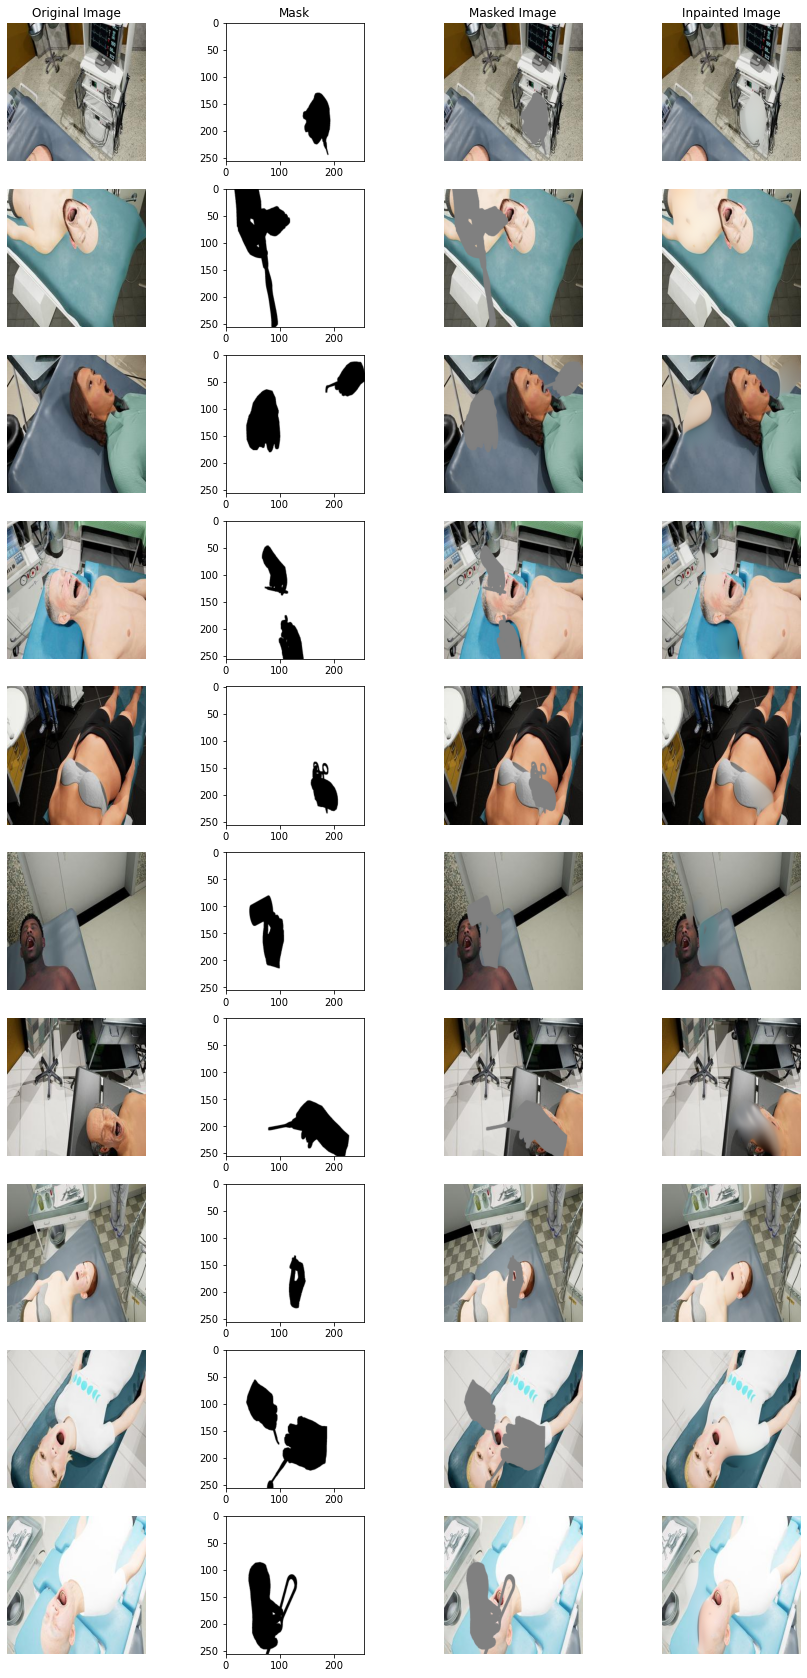

In [24]:
fig, ax = plt.subplots(len(vis_dataset), 4, figsize=(15, 30))

# print the img, mask, corresponding Apy and Gen images
for i, (img, mask, imgname) in enumerate(vis_dataset):
    # Access the image and mask data
    img = img.permute(1, 2, 0)
    mask = mask.permute(1, 2, 0)

    ax[i, 0].imshow(img)
    if i==0: ax[i, 0].set_title("Original Image")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(mask, cmap="gray")
    if i==0:  ax[i, 1].set_title("Mask")

    Apy = Image.open(os.path.join(output_folder_256r_8, f"Apy/{imgname}.png"))
    if i==0:  ax[i, 2].set_title("Masked Image")
    ax[i, 2].imshow(Apy)
    ax[i, 2].axis("off")

    Gen = Image.open(os.path.join(output_folder_256r_8, f"Gen/{imgname}.png"))
    if i==0:  ax[i, 3].set_title("Inpainted Image")
    ax[i, 3].imshow(Gen)
    ax[i, 3].axis("off")

plt.show()

### My Trained Model [12 epochs] w/ DDNM+

In [12]:
model_path = "models_new/trained_model_256r_12.pth"
output = "gen_output_256r_12/"
run_with_ddnm = True

#create output folder if it doesn't exist
output_folder_256r_12 = os.path.join(project_path, output)
if not os.path.exists(output_folder_256r_12):
    os.makedirs(output_folder_256r_12, exist_ok=True)

try:
    runner = Diffusion(vis_dataset, model_path, output_folder_256r_12, device=device)
    runner.sample(run_with_ddnm)
except Exception:
    logging.error(traceback.format_exc())

Running DDNM+...
Start from 0
curr_idx: 1 PSNR: 27.71
curr_idx: 1 SSIM: 0.96
curr_idx: 2 PSNR: 28.70
curr_idx: 2 SSIM: 0.97
curr_idx: 3 PSNR: 27.92
curr_idx: 3 SSIM: 0.94
curr_idx: 4 PSNR: 28.35
curr_idx: 4 SSIM: 0.97
curr_idx: 5 PSNR: 28.61
curr_idx: 5 SSIM: 0.98
curr_idx: 6 PSNR: 29.59
curr_idx: 6 SSIM: 0.98
curr_idx: 7 PSNR: 29.15
curr_idx: 7 SSIM: 0.94
curr_idx: 8 PSNR: 29.95
curr_idx: 8 SSIM: 0.99
curr_idx: 9 PSNR: 29.45
curr_idx: 9 SSIM: 0.94
curr_idx: 10 PSNR: 29.28
curr_idx: 10 SSIM: 0.95
Total Average PSNR: 29.28
Total SSIM mean: 0.96 and std dev: 0.02
Number of samples: 10


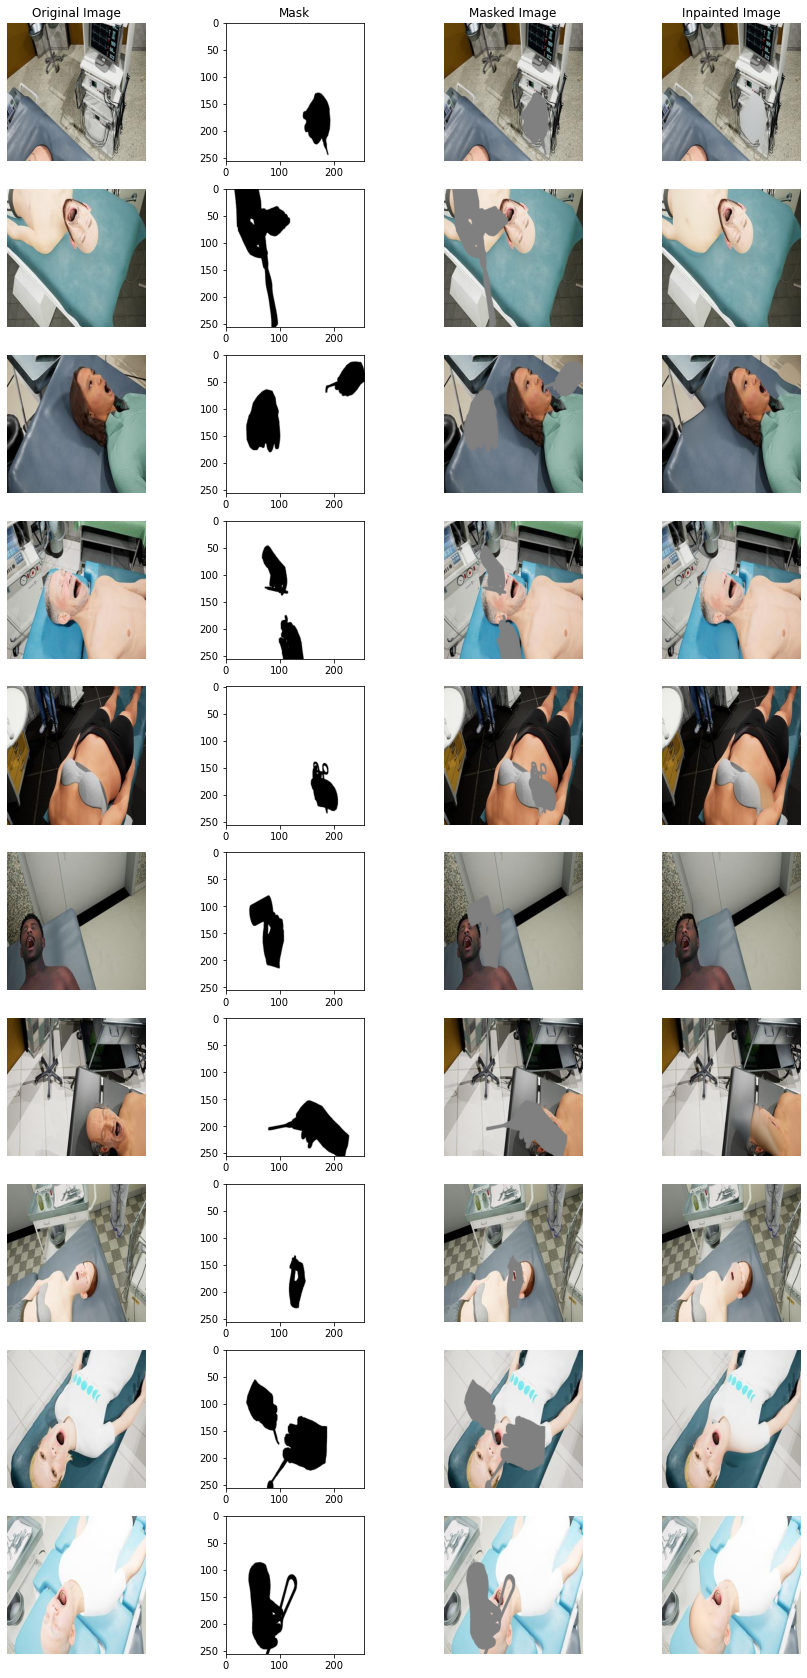

In [13]:
fig, ax = plt.subplots(len(vis_dataset), 4, figsize=(15, 30))

# print the img, mask, corresponding Apy and Gen images
for i, (img, mask, imgname) in enumerate(vis_dataset):
    # Access the image and mask data
    img = img.permute(1, 2, 0)
    mask = mask.permute(1, 2, 0)

    ax[i, 0].imshow(img)
    if i==0: ax[i, 0].set_title("Original Image")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(mask, cmap="gray")
    if i==0:  ax[i, 1].set_title("Mask")

    Apy = Image.open(os.path.join(output_folder_256r_12, f"Apy/{imgname}.png"))
    if i==0:  ax[i, 2].set_title("Masked Image")
    ax[i, 2].imshow(Apy)
    ax[i, 2].axis("off")

    Gen = Image.open(os.path.join(output_folder_256r_12, f"Gen/{imgname}.png"))
    if i==0:  ax[i, 3].set_title("Inpainted Image")
    ax[i, 3].imshow(Gen)
    ax[i, 3].axis("off")

plt.show()

### My Trained Model [15 epochs] w/ DDNM+

In [14]:
model_path = "models_new/trained_model_256r_15.pth"
output = "gen_output_256r_15/"
run_with_ddnm = True

#create output folder if it doesn't exist
output_folder_256r_15 = os.path.join(project_path, output)
if not os.path.exists(output_folder_256r_15):
    os.makedirs(output_folder_256r_15, exist_ok=True)

try:
    runner = Diffusion(vis_dataset, model_path, output_folder_256r_15, device=device)
    runner.sample(run_with_ddnm)
except Exception:
    logging.error(traceback.format_exc())

Running DDNM+...
Start from 0
curr_idx: 1 PSNR: 26.35
curr_idx: 1 SSIM: 0.96
curr_idx: 2 PSNR: 27.50
curr_idx: 2 SSIM: 0.97
curr_idx: 3 PSNR: 27.52
curr_idx: 3 SSIM: 0.95
curr_idx: 4 PSNR: 27.90
curr_idx: 4 SSIM: 0.97
curr_idx: 5 PSNR: 28.31
curr_idx: 5 SSIM: 0.98
curr_idx: 6 PSNR: 29.33
curr_idx: 6 SSIM: 0.98
curr_idx: 7 PSNR: 28.64
curr_idx: 7 SSIM: 0.94
curr_idx: 8 PSNR: 29.08
curr_idx: 8 SSIM: 0.98
curr_idx: 9 PSNR: 28.57
curr_idx: 9 SSIM: 0.94
curr_idx: 10 PSNR: 28.51
curr_idx: 10 SSIM: 0.95
Total Average PSNR: 28.51
Total SSIM mean: 0.96 and std dev: 0.02
Number of samples: 10


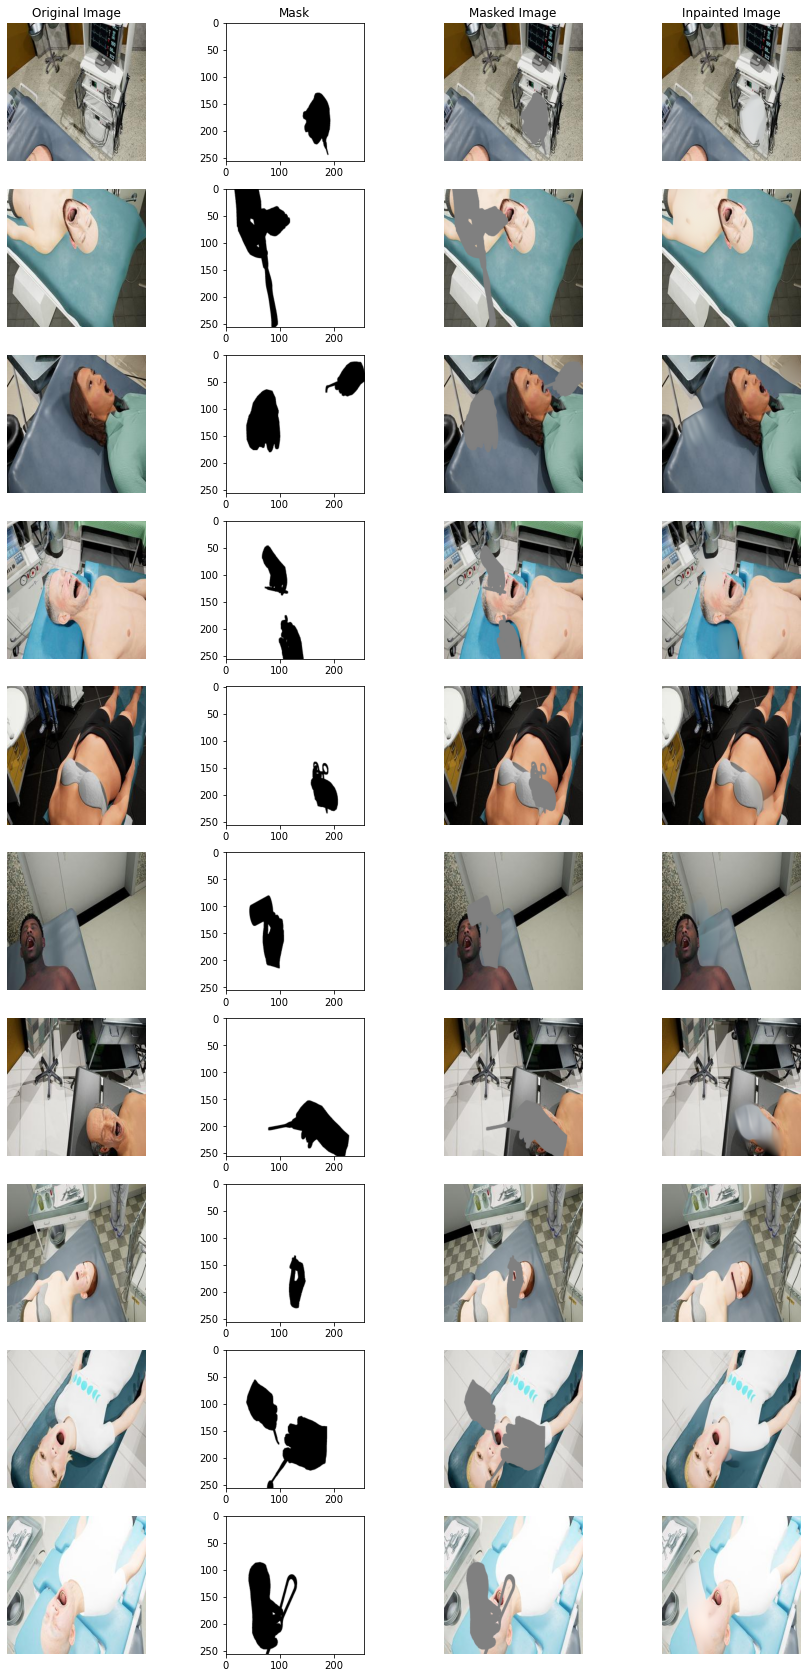

In [15]:
fig, ax = plt.subplots(len(vis_dataset), 4, figsize=(15, 30))

# print the img, mask, corresponding Apy and Gen images
for i, (img, mask, imgname) in enumerate(vis_dataset):
    # Access the image and mask data
    img = img.permute(1, 2, 0)
    mask = mask.permute(1, 2, 0)

    ax[i, 0].imshow(img)
    if i==0: ax[i, 0].set_title("Original Image")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(mask, cmap="gray")
    if i==0:  ax[i, 1].set_title("Mask")

    Apy = Image.open(os.path.join(output_folder_256r_15, f"Apy/{imgname}.png"))
    if i==0:  ax[i, 2].set_title("Masked Image")
    ax[i, 2].imshow(Apy)
    ax[i, 2].axis("off")

    Gen = Image.open(os.path.join(output_folder_256r_15, f"Gen/{imgname}.png"))
    if i==0:  ax[i, 3].set_title("Inpainted Image")
    ax[i, 3].imshow(Gen)
    ax[i, 3].axis("off")

plt.show()